---
title: NonLinear Shallow Water Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: NonLinear SWM
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: tuchida@fsu.edu
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import pandas as pd
from jaxsw._src.domain.base import Domain
from jaxsw._src.fields.base import Field
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.operators.fd import Difference
from jaxsw._src.operators.custom import FuncOperator

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/tuchida/miniconda3/envs/jax310/lib/python3.10/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


## Formulation

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ H
\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0 \\
\frac{\partial u}{\partial t} &- fv =
- g \frac{\partial h}{\partial x}
- \kappa u \\
\frac{\partial v}{\partial t} &+ fu =
- g \frac{\partial h}{\partial y}
- \kappa v
\end{aligned}
$$ (eq:sw_linear)




Taking the equation from [wikipedia](https://en.wikipedia.org/wiki/Shallow_water_equations#Non-conservative_form).

**Non-Conservative Form**

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ 
\frac{\partial}{\partial x}\left((H+h)u\right) +
\frac{\partial}{\partial y}\left((H+h)v\right)= 0 \\
\frac{\partial u}{\partial t} &+ u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} - fv =
-g\frac{\partial h}{\partial x} -ku + \nu \left( \frac{\partial^2 u}{\partial x^2} + 
\frac{\partial^2 u}{\partial y^2} \right)\\
\frac{\partial v}{\partial t} &+ u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} + fu =
-g\frac{\partial h}{\partial y} -kv + 
\nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)\\
\end{aligned}
$$ (eq:sw)

| Symbol | Variable | Unit | 
|:---------:|:------|:----:|
| $u$ | Zonal Velocity |  $m/s^2$ |
| $v$ | Meridial Velocity |   $m/s^2$ |
| $H$ |Mean Height |   $m$ |
| $h$ |Height Deviation |$m$ |
|$b$ | Topographical height 


**Velocities**. The $u,v$ represent the zonal and meridional velocities in the x,y directions respectively.

**Heights** ($H,h,b$). 
The $H$ represents the mean hight of the horizontal pressure surface. 
The $h$ represents the height deviation of the horizontal pressure surface from its mean height.
$b$ represents the topographical height from a reference $D$.

$$
\begin{aligned}
\eta(x,y,t) &= H(x,y) + h(x,y,t) \\
H(x,y) &= D + b(x,y)
\end{aligned}
$$

**Constants** ($f,k,\nu$). $g$ is the acceleration due to gravity, $k$ is the viscous drag coefficient, and $\nu$ is the kinematic viscosity.

**NonLinear SW Example**

* Varying Coriolis Force
* NonLinear Terms
* Lateral Friction
* Periodic Boundary Conditions

## Domain



In [2]:
dx = dy = 5e3
Lx = 200 * dx
Ly = 104 * dy


# initialize the h domain
h_domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy))

# initialize the u-velocity domain
u_domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy), stagger=("right", None))

# initialize the v-velocity domain
v_domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy), stagger=(None, "right"))

# initialize the q domain
q_domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy), stagger=("right", "right"))


print(f"Nx: {h_domain.Nx}")
print(f"Lx: {h_domain.Lx}")
print(f"dx: {h_domain.dx}")
print(f"Size: {h_domain.size}")
print(f"nDims: {h_domain.ndim}")
print(f"Grid Size: {h_domain.grid.shape}")
print(f"Cell Volume: {h_domain.cell_volume:_}")

Nx: (201, 105)
Lx: (1000000.0, 520000.0)
dx: (5000.0, 5000.0)
Size: (201, 105)
nDims: 2
Grid Size: (201, 105, 2)
Cell Volume: 25_000_000.0


## State + Parameters

In [19]:
class Params(tp.NamedTuple):
    depth: float
    gravity: float
    coriolis_f0: float  # or ARRAY
    coriolis_beta: float  # or ARRAY

    @property
    def phase_speed(self):
        return jnp.sqrt(self.gravity * self.depth)
        
    @property
    def rossby_radius(self):
        return self.phase_speed / self.coriolis_f0.mean()

    def coriolis_param(self, domain):
        return self.coriolis_f0 + domain.grid[..., 1] * self.coriolis_beta

    def lateral_viscosity(self, domain):
        return 1e-3 * self.coriolis_f0 * domain.dx[0] ** 2

In [20]:
params = Params(
    gravity=9.81, depth=100.0, coriolis_f0=2e-4, coriolis_beta=2e-11,
)

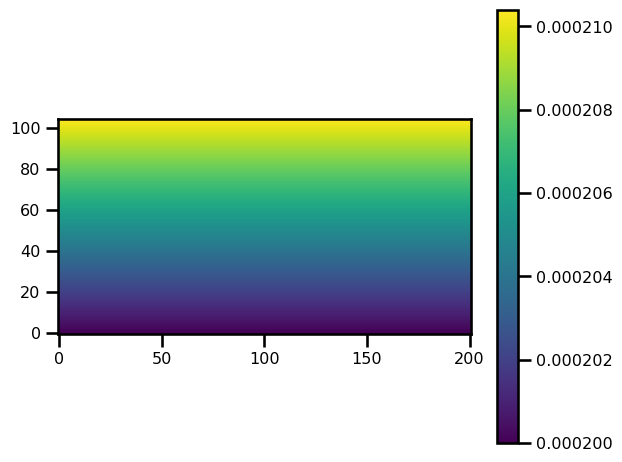

In [5]:
fig, ax = plt.subplots()

pts = ax.imshow(params.coriolis_param(h_domain).T, origin="lower")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

## Initial Condition

In [21]:
def init_u0(domain):
    # grab coordinate values
    y = domain.coords[1]
    # grab grid coordinate values
    Y = domain.grid[..., 1]
    # grab number of points - y direction
    n_y = domain.Nx[1]
    # grabs physical length of domain - x direction
    l_x = domain.Lx[0]
    # makes a Gaussian Ridge?
    u0 = 10 * jnp.exp(-((Y - y[n_y // 2]) ** 2) / (0.02 * l_x) ** 2)

    return jnp.asarray(u0)


def init_h0(domain, params):
    # parse parameters and domain
    dy = domain.dx[1]
    coriolis_param = params.coriolis_param(domain)
    gravity = params.gravity
    depth = params.depth

    # grab grid coordinate values
    X, Y = domain.grid[..., 0], domain.grid[..., 1]

    # grab number of points - y direction
    n_y = domain.Nx[1]

    # grabs physical length of domain - x direction
    l_x, l_y = domain.Lx

    # call u0
    u0 = init_u0(domain)
    # approximate balance h_y = -(f/g)u
    h0 = jnp.cumsum(-dy * u0 * coriolis_param / gravity, axis=1)

    # remove mean (make sure h0 is centered around depth)
    h0 -= h0.mean()

    # add depth
    h0 += depth

    # add small perturbation
    h0 += 0.2 * jnp.sin(X / l_x * 10 * jnp.pi) * jnp.cos(Y / l_y * 8 * jnp.pi)

    return jnp.asarray(h0)

In [29]:
class State(tp.NamedTuple):
    u: Field
    v: Field
    h: Field

    @classmethod
    def init_state(cls, params):
        h = Field(init_h0(h_domain, params), h_domain)
        u = Field(init_u0(h_domain), u_domain)
        v = Field(jnp.zeros_like(h.values), v_domain)

        return cls(u=u, v=v, h=h)

In [40]:
state_init = State.init_state(params)
print(state_init.u.values.max(), state_init.u.values.min(),
      state_init.u.values.mean(), np.median(state_init.u.values)
     )

10.0 4.0200602157433554e-73 0.6752205146306713 4.4777324417183015e-18


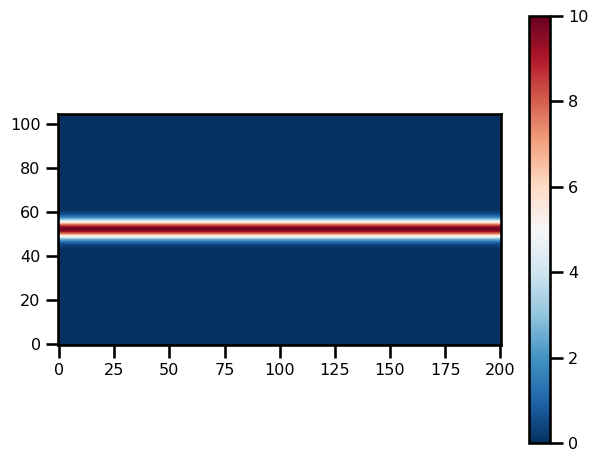

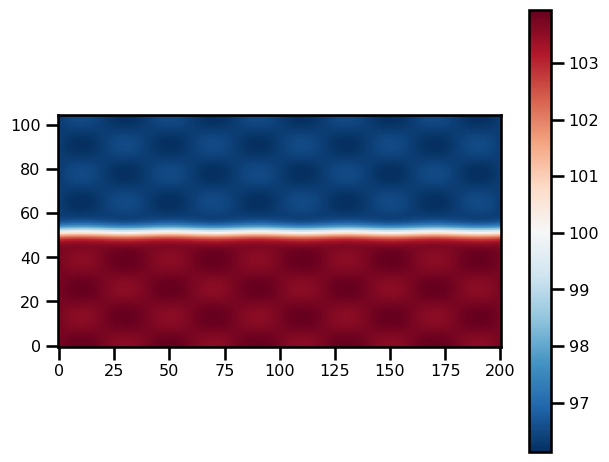

In [31]:
fig, ax = plt.subplots()

pts = ax.imshow(state_init.u[:].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()

pts = ax.imshow(state_init.h[:].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

## Boundary Conditions

**Period Case**:

* h, u, v - periodic in x
* v - northern boundary as zero

**NonPeriodic Case**:

* h - nothing
* u - east boundary as zero
* v - northern boundary as zero

In [32]:
def bc_periodic(u: Array,):
    u = u.at[0, :].set(u[-2, :])
    u = u.at[-1, :].set(u[1, :])
    
    return u
    

def bc_u(u: Array, periodic_x: bool = False):
    if periodic_x:
        u = bc_periodic(u)
    else:
        u = u.at[-2, :].set(0.)
        
    return u


def bc_v(v: Array, periodic_x: bool = False):
    if periodic_x:
        v = bc_periodic(v)
    v = v.at[:, -2].set(0.0)
    
    return v


def bc_h(h: Array, periodic_x: bool = False):
    if periodic_x:
        h = bc_periodic(h)
        
    return h

In [32]:
FuncOperator??

Init signature: FuncOperator(*args, **kwargs)
Docstring:      FuncOperator(*args, **kwargs)
Source:        
class FuncOperator(eqx.Module):
    f: Callable = eqx.static_field()

    def __init__(self, f):
        self.f = f

    def __call__(self, u: Field, *args, **kwargs) -> Field:
        u = eqx.tree_at(lambda x: x.values, u, self.f(u.values, *args, **kwargs))

        return u
File:           ~/Documents/Python/jaxsw/jaxsw/_src/operators/custom.py
Type:           _ModuleMeta
Subclasses:     FuncOperator

In [33]:
bc_u_op = FuncOperator(bc_u)
bc_v_op = FuncOperator(bc_v)
bc_h_op = FuncOperator(bc_h)
u_bc = bc_u_op(state_init.u)
u_bc_periodic = bc_u_op(state_init.u, periodic_x=True)
h_bc = bc_h_op(state_init.h)
h_bc_periodic = bc_h_op(state_init.h, periodic_x=True)
u_bc_periodic

Field(
  values=f64[201,105],
  domain=Domain(
    xmin=(2500.0, 0.0),
    xmax=(1002500.0, 520000.0),
    dx=(5000.0, 5000.0)
  )
)

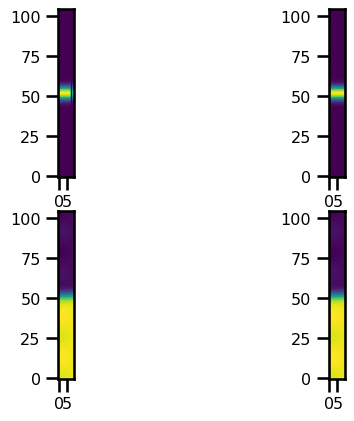

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].imshow(u_bc[-10:].T, origin="lower")
ax[0, 1].imshow(u_bc_periodic[-10:].T, origin="lower")
ax[1, 0].imshow(h_bc[-10:].T, origin="lower")
ax[1, 1].imshow(h_bc_periodic[-10:].T, origin="lower")

plt.show()

In [34]:
class Grid_diff(eqx.Module):
    axis: int = eqx.static_field()
    accuracy: int = eqx.static_field()
    method: str = eqx.static_field()
    direction: str = eqx.static_field()

    def __init__(
        self,
        axis: int = 0,
        accuracy: int = 1,
        direction: str = "right",
    ):
        if direction == 'right':
            method = 'forward'
        elif direction == 'left':
            method = 'backward'
        else:
            raise ValueError("Someone F uped")
            
        self.axis = axis
        self.accuracy = accuracy
        self.method = method
        self.direction = direction

    def __call__(
        self, u: Field, step_size: tp.Optional[Array] = None, axis: int = None
    ) -> Field:
        axis = self.axis if axis is None else axis
        step_size = u.domain.dx[self.axis] if step_size is None else step_size

        out = jnp.zeros_like(u.values)
        out = out.at[1:-1,1:-1].set(fdx.difference(
            u.values[1:-1,1:-1],
            axis=axis,
            accuracy=self.accuracy,
            step_size=step_size,
            derivative=1,
            method=self.method,
        )
                                   )
        assert out.shape == u.values.shape

        if axis == 0:
            stagger = (self.direction,None)
        elif axis == 1:
            stagger = (None,self.direction)
        else:
            raise NotImplementedError("F uped again")
            
        domain = Domain(xmin=u.domain.xmin, xmax=u.domain.xmax, dx=u.domain.dx, stagger=stagger)
        
        u = Field(out, domain)

        return u

In [23]:
print(state_init.h.values)
print(state_init.h.values.max(), state_init.h.values.min(),
      state_init.h.values.mean(), np.median(state_init.h.values)
     )

[[103.74255252 103.74255252 103.74255252 ...  96.32751623  96.32751623
   96.32751623]
 [103.77383942 103.77293028 103.77025569 ...  96.3552194   96.35789398
   96.35880312]
 [103.80435592 103.80256003 103.79727672 ...  96.38224042  96.38752373
   96.38931963]
 ...
 [103.68074913 103.68254502 103.68782833 ...  96.27279204  96.26750873
   96.26571283]
 [103.71126563 103.71217477 103.71484936 ...  96.29981306  96.29713848
   96.29622934]
 [103.74255252 103.74255252 103.74255252 ...  96.32751623  96.32751623
   96.32751623]]
103.94255252421287 96.12751623051639 100.00000000000004 99.51613332634949


### Height Equation

Remember [](#eq:sw) 

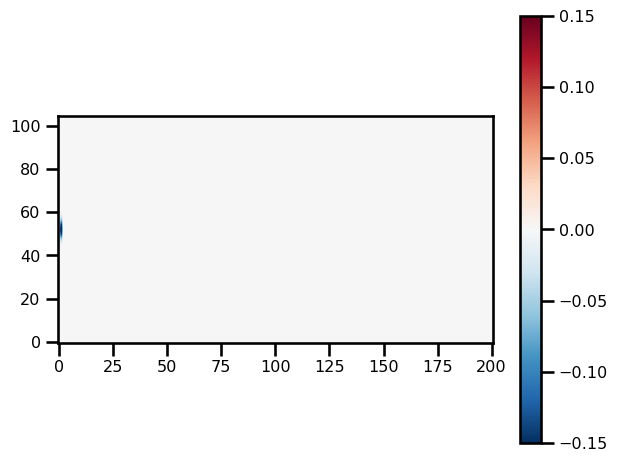

In [39]:
def enforce_boundaries(u, grid: str, periodic_x: bool = False):
    assert grid in ["h", "u", "v"]

    if periodic_x:
        u = u.at[0, :].set(u[-2, :])
        u = u.at[-1, :].set(u[1, :])

    elif grid == "u":
        u = u.at[-2, :].set(0.0)

    if grid == "v":
        u = u.at[:, -2].set(0.0)

    return u
    

def equation_of_motion(state, params):
    """
    ∂h/∂t + (∂(hu)/∂x + ∂(hv)/∂y) = 0
    """

    h, u, v = state.h.values, state.u.values, state.v.values

    h = enforce_boundaries(h, "h", False)
    v = enforce_boundaries(v, "v", False)
    u = enforce_boundaries(u, "u", False)

    # pad
    h_node = jnp.pad(h[1:-1, 1:-1], 1, "edge")
    h_node = enforce_boundaries(h_node, "h", False)

    # move h to u | (cell node) -> (top edge) | (cell center) --> (right edge)
    h_on_u = 0.5 * (h_node[1:-1, 1:-1] + h_node[2:, 1:-1])

    # move h to v | (cell node) --> (right edge) | (cell center) --> (top edge)
    h_on_v = 0.5 * (h_node[1:-1, 1:-1] + h_node[1:-1, 2:])

    # hu, hv (interior only)
    flux_on_u = jnp.zeros_like(h)
    flux_on_v = jnp.zeros_like(h)
    flux_on_u = flux_on_u.at[1:-1, 1:-1].set(h_on_u * u[1:-1, 1:-1])
    flux_on_v = flux_on_v.at[1:-1, 1:-1].set(h_on_v * v[1:-1, 1:-1])

    flux_on_u = enforce_boundaries(flux_on_u, "h", False)
    flux_on_v = enforce_boundaries(flux_on_v, "h", False)
    print(flux_on_u.shape)

    # finite difference
    # u --> h | top edge --> cell node | right edge --> cell center
    dh_dx = (flux_on_u[1:-1, 1:-1] - flux_on_u[:-2, 1:-1]) / domain.dx[0]
    # v --> h | right edge --> cell node | top edge --> cell center
    dh_dy = (flux_on_v[1:-1, 1:-1] - flux_on_v[1:-1, :-2]) / domain.dx[1]

    h_rhs = jnp.zeros_like(h)
    h_rhs = h_rhs.at[1:-1, 1:-1].set(-(dh_dx + dh_dy))
    # plt.imshow(h_rhs)

    # state = eqx.tree_at(lambda x: x.h, state, h_rhs)

   
    return h_rhs
    # return state

fig, ax = plt.subplots()

pts = ax.imshow(h_rhs[:,:].T, origin="lower", cmap='RdBu_r', vmin=-.15, vmax=.15)
plt.colorbar(pts)
plt.tight_layout()
plt.show()

In [17]:
def equation_of_motion_h(state, params):
    """
    ∂h/∂t + (∂(hu)/∂x + ∂(hv)/∂y) = 0
    """

    h, u, v = state.h, state.u, state.v

    # h = bc_h_op(h, False)
    # print(h.domain, u.domain, v.domain)

    # pad
    h_center = jnp.pad(h[1:-1, 1:-1], 1, "edge")
    # h_center = Field(h_center, h_domain)
    # h_center = bc_h_op(h_center, False)
    # print(h_center.domain)

    # # move h (cell node) to u (right edge | east interface)
    h_on_u = 0.5 * (h_center[1:-1, 1:-1] + h_center[2:, 1:-1])
    # h_on_u = F_grid.grid_operator(h_center, ("right",None))[1:-1,1:-1]
    # plt.imshow(h_on_u1 - h_on_u)
    # plt.show()

    # # move h (cell node) to v (top edge | north interface)
    h_on_v = 0.5 * (h_center[1:-1, 1:-1] + h_center[1:-1, 2:])
    # h_on_v = F_grid.grid_operator(h_center, (None,"right"))[1:-1,1:-1]
    # plt.imshow(h_on_v1 - h_on_v)
    # plt.show()

    # # hu, hv (interior only)
    flux_on_u = jnp.zeros_like(h.values)
    flux_on_v = jnp.zeros_like(h.values)
    flux_on_u = flux_on_u.at[1:-1, 1:-1].set(h_on_u * u[1:-1, 1:-1])
    flux_on_v = flux_on_v.at[1:-1, 1:-1].set(h_on_v * v[1:-1, 1:-1])
    # flux_right1 = h_on_u * u[1:-1, 1:-1]
    # flux_top1 = h_on_v * v[1:-1, 1:-1]

    # flux_on_u = bc_h_op(Field(flux_on_u, u.domain))
    # flux_on_v = bc_h_op(Field(flux_on_v, v.domain))

    # # # finite difference
    # dh_dx = Grid_diff(0, 1, "left")(flux_on_u)
    # dh_dy = Grid_diff(1, 1, "left")(flux_on_v)
    # dh_dx = fdx.difference(
    #         flux_on_u[:, :],
    #         axis=0,
    #         accuracy=1,
    #         step_size=h.domain.dx[0],
    #         derivative=1,
    #         method='forward',
    #     )[1:-1,1:-1]
    # dh_dy = fdx.difference(
    #         flux_on_v[:],
    #         axis=1,
    #         accuracy=1,
    #         step_size=h.domain.dx[1],
    #         derivative=1,
    #         method='forward',
    #     )[1:-1, 1:-1]
    # # print(dh_dx.domain, dh_dy.domain)
    dh_dx = (flux_on_u[1:-1, 1:-1] - flux_on_u[:-2, 1:-1]) / h.domain.dx[0]
    dh_dy = (flux_on_v[1:-1, 1:-1] - flux_on_v[1:-1, :-2]) / h.domain.dx[1]
    # plt.imshow(dh_dy.values[1:-1, 1:-1] - dh_dy1)

    h_rhs = jnp.zeros_like(h.values)
    h_rhs = h_rhs.at[1:-1, 1:-1].set(-(dh_dx + dh_dy))
    # h_rhs = -(dh_dx + dh_dy)

    # state = eqx.tree_at(lambda x: x.h, state, h_rhs)

    return h_rhs

In [14]:
h_rhs = equation_of_motion_h(state_init, params)

In [30]:
print(h_rhs.min(), h_rhs.max(),
      h_rhs.mean(), np.median(h_rhs))

-0.199125356944582 6.257378601605979e-05 -6.694650957393678e-05 0.0


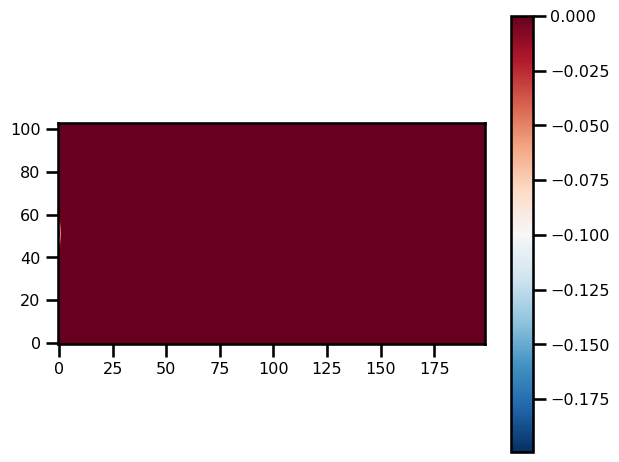

In [15]:
fig, ax = plt.subplots()

pts = ax.imshow(h_rhs[1:-1,1:-1].T, origin="lower", cmap='RdBu_r')
plt.colorbar(pts)
plt.tight_layout()
plt.show()

### U-Velocity

Remember [](#eq:sw) 

**Note**: written in *vector invariant momentum* form ([see MITGCM manual](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#vector-invariant-momentum-equations) | [Wikipedia](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations#Compressible_flow))

**TODO**: Is there any advantage to this?

$$
\begin{aligned}
\text{Potential Vorticity}: && 
\frac{\text{Planetary Vort} + \text{Relative Vort.}}{\text{Height}}
\\
\text{Planetary Vorticity}: && f \\
\text{Relative Vorticity}: && \partial_x v - \partial_y u \\
\end{aligned}
$$


In [23]:
def equation_of_motion_u(state, params):
    """
    ∂h/∂t + (∂(hu)/∂x + ∂(hv)/∂y) = 0
    """

    h, u, v = state.h, state.u, state.v

    h = bc_h_op(h, False)
    v = bc_v_op(v, False)
    u = bc_u_op(u, False)

    # planetary and relative vorticity
    planetary_vort = params.coriolis_param(h.domain)[1:-1, 1:-1]

    # relative vorticity
    # v --> q | right edge --> cell face | top edge --> cell node
    # dv_dx = (v[2:, 1:-1] - v[1:-1, 1:-1]) / domain.dx[0]
    dv_dx = Grid_diff(0, 1, "right")(v)[2:, 1:-1]
    # plt.imshow(dv_dx - dv_dx1)
    # plt.show()
    # u --> q | top edge --> cell face | right edge --> cell node
    # du_dy1 = (u[1:-1, 2:] - u[1:-1, 1:-1]) / u.domain.dx[1]
    du_dy = Grid_diff(1, 1, "left")(u)[1:-1, 2:]
    relative_vort = dv_dx - du_dy

    # calculate potential vorticity

    # h --> q | cell node --> cell face | cell face --> cell node
    # move h (cell node) to vort (cell center)
    # h_on_vort = 0.25 * (
    #     h_node[1:-1, 1:-1] + h_node[2:, 1:-1] + h_node[1:-1, 2:] + h_node[2:, 2:]
    # )
    h_center = jnp.pad(h[1:-1, 1:-1], 1, "edge")
    h_center = Field(h_center, h_domain)
    h_center = bc_h_op(h_center, False)
    h_on_vort = F_grid.grid_operator(h_center, ("inner","inner"))

    potential_vort = jnp.zeros_like(h.values)
    potential_vort = potential_vort.at[1:-1, 1:-1].set(
        (planetary_vort + relative_vort) / h_on_vort[1:, 1:]
    )
    # plt.imshow(potential_vort)

    # # enforce boundaries
    # potential_vort = enforce_boundaries(potential_vort, "h", False)

    h_on_v = F_grid.grid_operator(h_center, (None,"right"))[1:-1,1:-1]
    # # hu, hv (interior only)
    flux_on_v = jnp.zeros_like(h.values)
    flux_on_v = flux_on_v.at[1:-1, 1:-1].set(h_on_v * v[1:-1, 1:-1])
    
    flux_on_v = bc_h_op(Field(flux_on_v, v.domain))

    flux_on_q = F_grid.grid_operator(flux_on_v, ("right",None))
    adv_rhs = jnp.ones_like(potential_vort)
    adv_rhs = adv_rhs.at[1:-1].set(potential_vort[1:-1]*flux_on_q.values[1:-1])
    # # flux on v (top edge) ---> vort (cell center)
    # # v --> q | | right edge --> cell face | top edge --> cell node
    # # flux_on_q_l = 0.5 * (flux_on_v[1:-1, 1:-1] + flux_on_v[2:, 1:-1])
    # flux_on_q_l = flux_on_q[:,1:-1]

    # # v --> q | | right edge --> cell face | top edge --> cell node
    # # flux_on_q_r = 0.5 * (flux_on_v[1:-1, :-2] + flux_on_v[2:, :-2])
    # flux_on_q_r = flux_on_q[:,:-2]

    # # advection
    # # q--> u | cell face --> top edge |  cell node --> right edge
    # adv_rhs = 0.5 * (
    #     potential_vort[1:-1, 1:-1] * flux_on_q_l
    #     + potential_vort[1:-1, :-2] * flux_on_q_r
    # )
    adv_rhs = F_grid.grid_operator(Field(adv_rhs, q_domain), 
                                   (None,"right"))[1:-1,:-2]
    # plt.imshow(adv_rhs)

    # # kinetic energy
    ke_on_h = jnp.zeros_like(h.values)

    # # u --> h | top edge --> cell node | right edge --> cell center
    # u2_on_h = 0.5 * (u[1:-1, 1:-1] ** 2 + u[:-2, 1:-1] ** 2)
    u2_on_h = F_grid.grid_operator(u**2, ("right",None))[:-2,1:-1]
    # # v --> h | right edge --> cell node | top edge --> cell center
    # v2_on_h = 0.5 * (v[1:-1, 1:-1] ** 2 + v[1:-1, :-2] ** 2)
    v2_on_h = F_grid.grid_operator(v**2, (None,"right"))[1:-1,:-2]

    ke_on_h = ke_on_h.at[1:-1, 1:-1].set(0.5 * (u2_on_h + v2_on_h))
    # plt.imshow(ke_on_h)

    # # enforce boundary conditions
    # ke_on_h = enforce_boundaries(ke_on_h, "h", False)
    # # move h to u | (cell node) -> (top edge) | (cell center) --> (right edge)
    # dke_on_u = -(ke_on_h[2:, 1:-1] - ke_on_h[1:-1, 1:-1]) / domain.dx[0]
    dke_on_u = -Grid_diff(0, 1, "right")(Field(ke_on_h, h_domain)
                                       )[2:,1:-1]
    # plt.imshow(dke_on_u, vmax=1e-3)
    # plt.colorbar()
    # print(dke_on_u.shape)

    # # pressure work
    # # move h to u | (cell node) -> (top edge) | (cell center) --> (right edge)
    # p_work = -params.gravity * (h[2:, 1:-1] - h[1:-1, 1:-1]) / domain.dx[0]
    p_work = Grid_diff(0,1,"right")(h)[2:,1:-1]
    p_work *= -params.gravity

    # print(h)
    u_rhs = jnp.zeros_like(h.values)
    u_rhs = u_rhs.at[1:-1, 1:-1].set(adv_rhs + p_work + dke_on_u)

    # # # state = eqx.tree_at(lambda x: x.u, state, u_rhs)

    return u_rhs

103.93843342773734 96.13163532699194 99.99966313098695 99.53185516402074


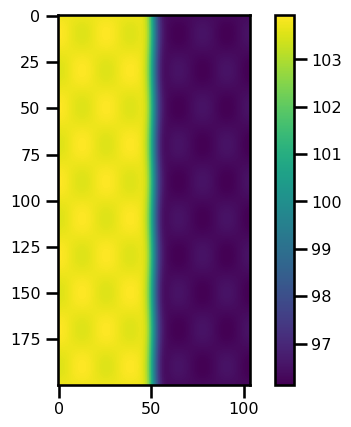

In [44]:
u_rhs = equation_of_motion_u(state_init, params)
# plt.imshow(u_rhs)
# plt.colorbar()

In [24]:
def equation_of_motion_v(state, params):
    """
    ∂h/∂t + (∂(hu)/∂x + ∂(hv)/∂y) = 0
    """

    h, u, v = state.h, state.u, state.v

    h = bc_h_op(h, False)
    v = bc_v_op(v, False)
    u = bc_u_op(u, False)

    # planetary and relative vorticity
    planetary_vort = params.coriolis_param(h.domain)[1:-1, 1:-1]

    # relative vorticity
    # v --> q | right edge --> cell face | top edge --> cell node
    # dv_dx1 = (v[2:, 1:-1] - v[1:-1, 1:-1]) / v.domain.dx[0]
    dv_dx = Grid_diff(0, 1, "right")(v)[2:, 1:-1]
    # plt.imshow(dv_dx - dv_dx1)
    # plt.show()
    # u --> q | top edge --> cell face | right edge --> cell node
    # du_dy1 = (u[1:-1, 2:] - u[1:-1, 1:-1]) / u.domain.dx[1]
    du_dy = Grid_diff(1, 1, "left")(u)[1:-1, 2:]
    # plt.imshow(du_dy - du_dy1)
    # plt.show()
    relative_vort = dv_dx - du_dy

    # calculate potential vorticity

    # h --> q | cell node --> cell face | cell face --> cell node
    # move h (cell node) to vort (cell center)
    # h_on_vort = 0.25 * (
    #     h_node[1:-1, 1:-1] + h_node[2:, 1:-1] + h_node[1:-1, 2:] + h_node[2:, 2:]
    # )
    h_center = jnp.pad(h[1:-1, 1:-1], 1, "edge")
    h_center = Field(h_center, h_domain)
    h_center = bc_h_op(h_center, False)
    h_on_vort = F_grid.grid_operator(h_center, ("inner","inner"))

    potential_vort = jnp.zeros_like(h.values)
    potential_vort = potential_vort.at[1:-1, 1:-1].set(
        (planetary_vort + relative_vort) / h_on_vort[1:, 1:]
    )
    # h_on_vort = 0.25 * (
    #     h_center[1:-1, 1:-1] + h_center[2:, 1:-1] 
    #     + h_center[1:-1, 2:] + h_center[2:, 2:]
    # )
    
    # potential_vort = jnp.zeros_like(h.values)
    # potential_vort = potential_vort.at[1:-1, 1:-1].set(
    #     (planetary_vort + relative_vort) / h_on_vort
    # )
#######################
    h_on_u = F_grid.grid_operator(h_center, ("right",None))[1:-1,1:-1]
    # # hu, hv (interior only)
    flux_on_u = jnp.zeros_like(h.values)
    flux_on_u = flux_on_u.at[1:-1, 1:-1].set(h_on_u * u[1:-1, 1:-1])

    flux_on_u = bc_h_op(Field(flux_on_u, u.domain))
##
    # h_on_u = 0.5 * (h_center[1:-1, 1:-1] + h_center[2:, 1:-1])

    # # hu, hv (interior only)
    # flux_on_u = jnp.zeros_like(h.values)
    # flux_on_u = flux_on_u.at[1:-1, 1:-1].set(h_on_u * u[1:-1, 1:-1])
#######################
    flux_on_q = F_grid.grid_operator(flux_on_u, (None,"right"))
    adv_rhs = jnp.zeros_like(potential_vort)
    adv_rhs = adv_rhs.at[:,1:-1].set(potential_vort[:,1:-1]*flux_on_q.values[:,1:-1])

    adv_rhs = -F_grid.grid_operator(Field(adv_rhs, q_domain), 
                                    ("right",None))[:-2,1:-1]
##
    # flux_on_q_l = 0.5 * (flux_on_u[1:-1, 1:-1] + flux_on_u[1:-1, 2:])

    # # u --> q | top edge --> cell face | right edge --> cell node
    # flux_on_q_r = 0.5 * (flux_on_u[:-2, 1:-1] + flux_on_u[:-2, 2:])

    # # advection
    # # q --> v | cell face --> right edge | cell node --> top edge
    # adv_rhs = -0.5 * (
    #     potential_vort[1:-1, 1:-1] * flux_on_q_l
    #     + potential_vort[:-2, 1:-1] * flux_on_q_r
    # )
    # print(adv_rhs.max(), adv_rhs.min(),
    #       adv_rhs.mean(), np.median(adv_rhs))
    # plt.imshow(adv_rhs, cmap='RdBu_r',vmax=4e-3, vmin=-4e-3)
    # plt.colorbar()
#######################
    # # kinetic energy
    ke_on_h = jnp.zeros_like(h.values)

    # # u --> h | top edge --> cell node | right edge --> cell center
    # u2_on_h = 0.5 * (u[1:-1, 1:-1] ** 2 + u[:-2, 1:-1] ** 2)
    u2_on_h = F_grid.grid_operator(u**2, ("right",None))[:-2,1:-1]
    # # v --> h | right edge --> cell node | top edge --> cell center
    # v2_on_h = 0.5 * (v[1:-1, 1:-1] ** 2 + v[1:-1, :-2] ** 2)
    v2_on_h = F_grid.grid_operator(v**2, (None,"right"))[1:-1,:-2]

    ke_on_h = ke_on_h.at[1:-1, 1:-1].set(0.5 * (u2_on_h + v2_on_h))
    # print(ke_on_h.max(), ke_on_h.min(),
    #       ke_on_h.mean(), np.median(ke_on_h))
    # plt.imshow(ke_on_h)
    # plt.colorbar()

    # # enforce boundary conditions
    # ke_on_h = enforce_boundaries(ke_on_h, "h", False)
    # # move h to u | (cell node) -> (top edge) | (cell center) --> (right edge)
    # dke_on_u = -(ke_on_h[2:, 1:-1] - ke_on_h[1:-1, 1:-1]) / domain.dx[0]
    dke_on_v = -Grid_diff(1, 1, "right")(Field(ke_on_h, h_domain)
                                       )[1:-1,1:-1]
    # print(dke_on_v.max(), dke_on_v.min(),
    #       dke_on_v.mean(), np.median(dke_on_v))
    # plt.imshow(dke_on_v)
    # plt.colorbar()

    # # pressure work
    # # move h to u | (cell node) -> (top edge) | (cell center) --> (right edge)
    # p_work1 = -params.gravity * (h[1:-1, 2:] - h[1:-1, 1:-1]) / h.domain.dx[1]
    p_work = Grid_diff(1,1,"right")(h)[1:-1,1:-1]
    p_work *= -params.gravity
    # plt.imshow(p_work1 - p_work)
    # plt.show()
    # print(adv_rhs.max(), adv_rhs.min(),
    #       adv_rhs.mean(), np.median(adv_rhs))
    # plt.imshow(adv_rhs)
    # plt.colorbar()
    # plt.show()
    # print(p_work.max(), p_work.min(),
    #       p_work.mean(), np.median(p_work))
    # plt.imshow(p_work)
    # plt.colorbar()
    # plt.show()
    # print(dke_on_v.max(), dke_on_v.min(),
    #       dke_on_v.mean(), np.median(dke_on_v))
    # plt.imshow(dke_on_v)
    # plt.colorbar()
    # plt.show()

    # # print(h)
    v_rhs = jnp.zeros_like(h.values)
    v_rhs = v_rhs.at[1:-1, 1:-1].set(adv_rhs + p_work + dke_on_v)
    # print(v_rhs.max(), v_rhs.min(),
    #       v_rhs.mean(), np.median(v_rhs))
    # plt.imshow(v_rhs)
    # plt.colorbar()
    # plt.show()
    # # # state = eqx.tree_at(lambda x: x.u, state, u_rhs)

    return v_rhs
    # return adv_rhs, p_work, dke_on_v

In [203]:
# v_rhs = equation_of_motion_v(state_init, params)
# # plt.imshow(v_rhs)
# # plt.colorbar()
adv_rhs, p_work, dke_on_v = equation_of_motion_v(state_init, params)

In [181]:


def equation_of_motion(state, params):
    """
    ∂h/∂t + (∂(hu)/∂x + ∂(hv)/∂y) = 0
    """

    h, u, v = state.h.values, state.u.values, state.v.values
    domain = state.h.domain

    h = enforce_boundaries(h, "h", False)
    v = enforce_boundaries(v, "v", False)
    u = enforce_boundaries(u, "u", False)

    # pad
    h_node = jnp.pad(h[1:-1, 1:-1], 1, "edge")
    h_node = enforce_boundaries(h_node, "h", False)

    # move h to u | (cell node) -> (top edge) | (cell center) --> (right edge)
    h_on_u = 0.5 * (h_node[1:-1, 1:-1] + h_node[2:, 1:-1])

    # move h to v | (cell node) --> (right edge) | (cell center) --> (top edge)
    h_on_v = 0.5 * (h_node[1:-1, 1:-1] + h_node[1:-1, 2:])

    # hu, hv (interior only)
    flux_on_u = jnp.zeros_like(h)
    flux_on_v = jnp.zeros_like(h)
    flux_on_u = flux_on_u.at[1:-1, 1:-1].set(h_on_u * u[1:-1, 1:-1])
    flux_on_v = flux_on_v.at[1:-1, 1:-1].set(h_on_v * v[1:-1, 1:-1])

    flux_on_u = enforce_boundaries(flux_on_u, "h", False)
    flux_on_v = enforce_boundaries(flux_on_v, "h", False)
    print(flux_on_u.shape)

    # finite difference
    # u --> h | top edge --> cell node | right edge --> cell center
    dh_dx = (flux_on_u[1:-1, 1:-1] - flux_on_u[:-2, 1:-1]) / domain.dx[0]
    # v --> h | right edge --> cell node | top edge --> cell center
    dh_dy = (flux_on_v[1:-1, 1:-1] - flux_on_v[1:-1, :-2]) / domain.dx[1]

    h_rhs = jnp.zeros_like(h)
    h_rhs = h_rhs.at[1:-1, 1:-1].set(-(dh_dx + dh_dy))
    # plt.imshow(h_rhs)

    state = eqx.tree_at(lambda x: x.h, state, h_rhs)

    # planetary and relative vorticity
    planetary_vort = params.coriolis_param(domain)[1:-1, 1:-1]

    # relative vorticity
    # v --> q | right edge --> cell face | top edge --> cell node
    dv_dx = (v[2:, 1:-1] - v[1:-1, 1:-1]) / domain.dx[0]
    # u --> q | top edge --> cell face | right edge --> cell node
    du_dy = (u[1:-1, 2:] - u[1:-1, 1:-1]) / domain.dx[1]
    relative_vort = dv_dx - du_dy

    # calculate potential vorticity

    # h --> q | cell node --> cell face | cell face --> cell node
    # move h (cell node) to vort (cell center)
    h_on_vort = 0.25 * (
        h_node[1:-1, 1:-1] + h_node[2:, 1:-1] + h_node[1:-1, 2:] + h_node[2:, 2:]
    )
    

    potential_vort = jnp.zeros_like(h)
    potential_vort = potential_vort.at[1:-1, 1:-1].set(
        (planetary_vort + relative_vort) / h_on_vort
    )
    # plt.imshow(potential_vort)

    # enforce boundaries
    potential_vort = enforce_boundaries(potential_vort, "h", False)
    
    # flux on v (top edge) ---> vort (cell center)
    # v --> q | | right edge --> cell face | top edge --> cell node
    flux_on_q_l = 0.5 * (flux_on_v[1:-1, 1:-1] + flux_on_v[2:, 1:-1])

    # v --> q | | right edge --> cell face | top edge --> cell node
    flux_on_q_r = 0.5 * (flux_on_v[1:-1, :-2] + flux_on_v[2:, :-2])

    # advection
    # q--> u | cell face --> top edge |  cell node --> right edge
    adv_rhs = 0.5 * (
        potential_vort[1:-1, 1:-1] * flux_on_q_l
        + potential_vort[1:-1, :-2] * flux_on_q_r
    )
    # plt.imshow(adv_rhs)

    # kinetic energy
    ke_on_h = jnp.zeros_like(h)

    # u --> h | top edge --> cell node | right edge --> cell center
    u2_on_h = 0.5 * (u[1:-1, 1:-1] ** 2 + u[:-2, 1:-1] ** 2)
    # v --> h | right edge --> cell node | top edge --> cell center
    v2_on_h = 0.5 * (v[1:-1, 1:-1] ** 2 + v[1:-1, :-2] ** 2)

    ke_on_h = ke_on_h.at[1:-1, 1:-1].set(0.5 * (u2_on_h + v2_on_h))
    # plt.imshow(ke_on_h)
    # plt.colorbar()
    # enforce boundary conditions
    ke_on_h = enforce_boundaries(ke_on_h, "h", False)
    # print(ke_on_h.max(), ke_on_h.min(),
    #       ke_on_h.mean(), np.median(ke_on_h))
    # plt.imshow(ke_on_h)
    # plt.colorbar()
    # move h to u | (cell node) -> (top edge) | (cell center) --> (right edge)
    dke_on_u = -(ke_on_h[2:, 1:-1] - ke_on_h[1:-1, 1:-1]) / domain.dx[0]
    # plt.imshow(dke_on_u, vmax=1e-3)
    # plt.colorbar()
    # print(dke_on_u.shape)
    # pressure work
    # move h to u | (cell node) -> (top edge) | (cell center) --> (right edge)
    p_work = -params.gravity * (h[2:, 1:-1] - h[1:-1, 1:-1]) / domain.dx[0]

    u_rhs = jnp.zeros_like(h)
    u_rhs = u_rhs.at[1:-1, 1:-1].set(adv_rhs + p_work + dke_on_u)
    # plt.imshow(u_rhs)
    # plt.colorbar()
    
    state = eqx.tree_at(lambda x: x.u, state, u_rhs)

    # u --> q | top edge --> cell face | right edge --> cell node
    flux_on_q_l = 0.5 * (flux_on_u[1:-1, 1:-1] + flux_on_u[1:-1, 2:])

    # u --> q | top edge --> cell face | right edge --> cell node
    flux_on_q_r = 0.5 * (flux_on_u[:-2, 1:-1] + flux_on_u[:-2, 2:])

    # advection
    # q --> v | cell face --> right edge | cell node --> top edge
    adv_rhs = -0.5 * (
        potential_vort[1:-1, 1:-1] * flux_on_q_l
        + potential_vort[:-2, 1:-1] * flux_on_q_r
    )
    # print(adv_rhs.max(), adv_rhs.min(),
    #       adv_rhs.mean(), np.median(adv_rhs))
    # plt.imshow(adv_rhs)
    # plt.colorbar()
    # plt.imshow(adv_rhs, cmap='RdBu_r',vmax=4e-3, vmin=-4e-3)
    # plt.colorbar()

    # move h to v | (cell node) --> (right edge) | (cell center) --> (top edge)
    dke_on_v = -(ke_on_h[1:-1, 2:] - ke_on_h[1:-1, 1:-1]) / domain.dx[1]
    # print(dke_on_v.max(), dke_on_v.min(),
    #       dke_on_v.mean(), np.median(dke_on_v))
    # plt.imshow(dke_on_v)
    # plt.colorbar()
    # pressure work
    # move h to v | (cell node) --> (right edge) | (cell center) --> (top edge)
    p_work = -params.gravity * (h[1:-1, 2:] - h[1:-1, 1:-1]) / domain.dx[1]
    # print(p_work.max(), p_work.min(),
    #       p_work.mean(), np.median(p_work))
    # plt.imshow(p_work)
    # plt.colorbar()
    print(adv_rhs.max(), adv_rhs.min(),
          adv_rhs.mean(), np.median(adv_rhs))
    plt.imshow(adv_rhs)
    plt.colorbar()
    plt.show()
    print(p_work.max(), p_work.min(),
          p_work.mean(), np.median(p_work))
    plt.imshow(p_work)
    plt.colorbar()
    plt.show()
    print(dke_on_v.max(), dke_on_v.min(),
          dke_on_v.mean(), np.median(dke_on_v))
    plt.imshow(dke_on_v)
    plt.colorbar()
    plt.show()
    v_rhs = jnp.zeros_like(h)
    v_rhs = v_rhs.at[1:-1, 1:-1].set(adv_rhs + p_work + dke_on_v)
    print(v_rhs.max(), v_rhs.min(),
          v_rhs.mean(), np.median(v_rhs))
    plt.imshow(v_rhs)
    plt.colorbar()
    plt.show()
    # state = eqx.tree_at(lambda x: x.v, state, v_rhs)

    return adv_rhs, p_work, dke_on_v

(201, 105)
0.001436300183992108 -0.004525198828414901 -0.0001405791625648073 -5.607279468973456e-25


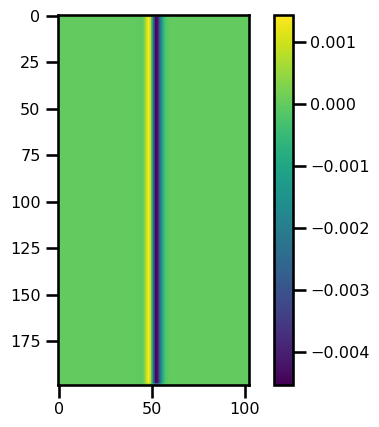

0.0020634024308420237 -9.459718666435845e-05 0.00014124564279837352 1.0159640271837533e-05


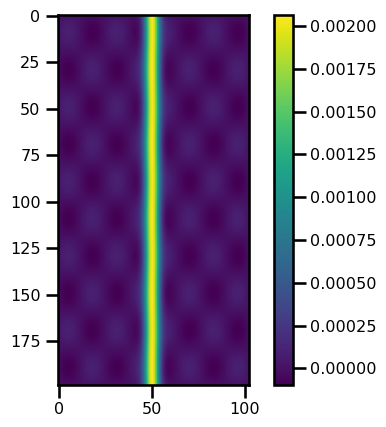

0.002818781923542837 -0.002818781923542837 0.0 6.30966891416096e-144


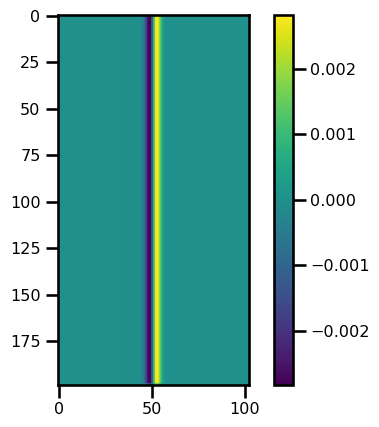

0.0021019800826071406 -0.000512508501459427 6.472800448901347e-07 0.0


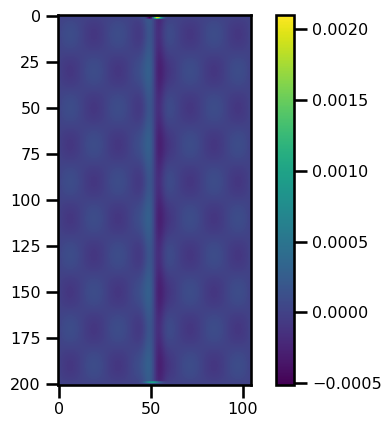

In [182]:
adv, p, dke = equation_of_motion(state_init, params)

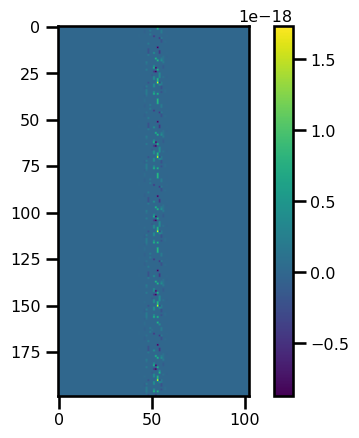

In [216]:
plt.imshow((adv_rhs[:,:] - adv[:,:]))
plt.colorbar()

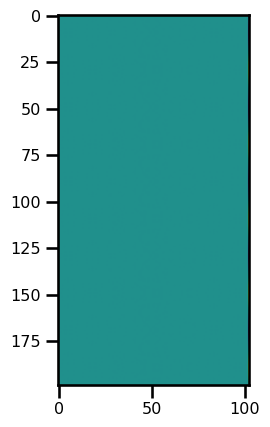

In [217]:
plt.imshow(p_work - p)

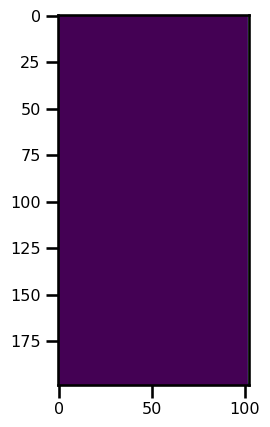

In [218]:
plt.imshow(dke_on_v - dke)

## Equation of Motion

In [37]:
class ShallowWater2D(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, state: State, args):
        """2D Linear Shallow Water Equations

        Equation:
            ∂h/∂t + (∂(hu)/∂x + ∂(hv)/∂y) = 0
            ∂u/∂t - fv = - g ∂h/∂x - ku
            ∂v/∂t + fu = - g ∂h/∂y - kv
        """
        #         # unpack state
        #         u, v, h = state.u, state.v, state.h

        #         # unpack params
        #         depth, coriolis, gravity, domain = (
        #             args.depth,
        #             args.coriolis,
        #             args.gravity,
        #             args.domain,
        #         )

        #         # # Apply Boundary Conditions
        #         # u = bc_fn(u)
        #         # v = bc_fn(v)
        #         u = u.at[-2, :].set(jnp.asarray(0.0))
        #         v = v.at[:, -2].set(jnp.asarray(0.0))

        #         ################
        #         # H COMPONENT
        #         # ∂h/∂t = - H (∂u/∂x + ∂v/∂y)
        #         ################
        #         h_rhs = jnp.zeros_like(h)

        #         du_dx = fdx.difference(
        #             u, axis=0, accuracy=1, method="backward", step_size=domain.dx[0]
        #         )
        #         dv_dy = fdx.difference(
        #             v, axis=1, accuracy=1, method="backward", step_size=domain.dx[1]
        #         )

        #         h_rhs = h_rhs.at[1:-1, 1:-1].set(
        #             -depth * (du_dx[1:-1, 1:-1] + dv_dy[1:-1, 1:-1])
        #         )

        #         ################
        #         # U COMPONENT
        #         # ∂u/∂t = fv - g ∂h/∂x
        #         ################
        #         u_rhs = jnp.zeros_like(u)

        #         v_avg = F_grid.center_average_2D(v, padding="valid")[1:, :-1]
        #         v_avg *= coriolis

        #         dh_dx = fdx.difference(
        #             h, axis=0, accuracy=1, method="forward", step_size=domain.dx[0]
        #         )
        #         dh_dx *= -gravity

        #         u_rhs = u_rhs.at[1:-1, 1:-1].set(v_avg + dh_dx[1:-1, 1:-1])

        #         ################
        #         # V COMPONENT
        #         # ∂v/∂t = - fu - g ∂h/∂y
        #         ###############

        #         v_rhs = jnp.zeros_like(v)

        #         u_avg = F_grid.center_average_2D(u, padding="valid")[:-1, 1:]
        #         u_avg *= -coriolis

        #         dh_dy = fdx.difference(
        #             h, axis=1, accuracy=1, method="forward", step_size=domain.dx[1]
        #         )
        #         dh_dy *= -gravity

        #         v_rhs = v_rhs.at[1:-1, 1:-1].set(u_avg + dh_dy[1:-1, 1:-1])

        #         # update state
        #         state = eqx.tree_at(lambda x: x.u, state, u_rhs)
        #         state = eqx.tree_at(lambda x: x.v, state, v_rhs)
        #         state = eqx.tree_at(lambda x: x.h, state, h_rhs)

        u_rhs = equation_of_motion_u(state, args)
        v_rhs = equation_of_motion_v(state, args)
        h_rhs = equation_of_motion_h(state, args)
        
        state = eqx.tree_at(lambda x: x.h.values, state, h_rhs)
        state = eqx.tree_at(lambda x: x.u.values, state, u_rhs)
        state = eqx.tree_at(lambda x: x.v.values, state, v_rhs)

        return state

In [26]:
state_update = ShallowWater2D.equation_of_motion(0, state_init, params)

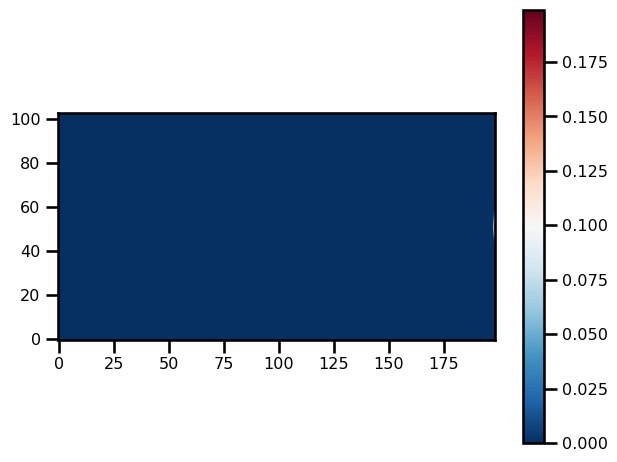

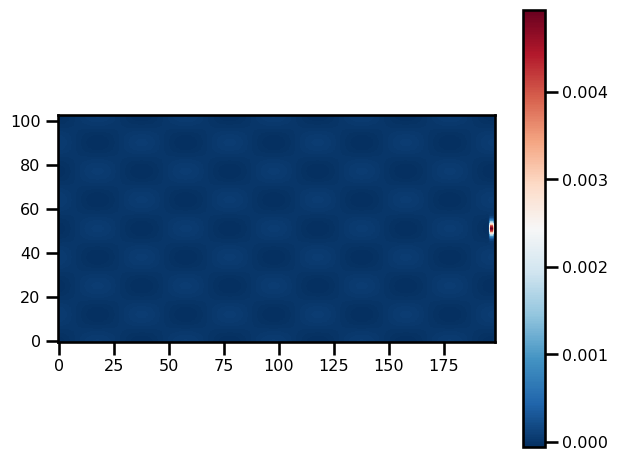

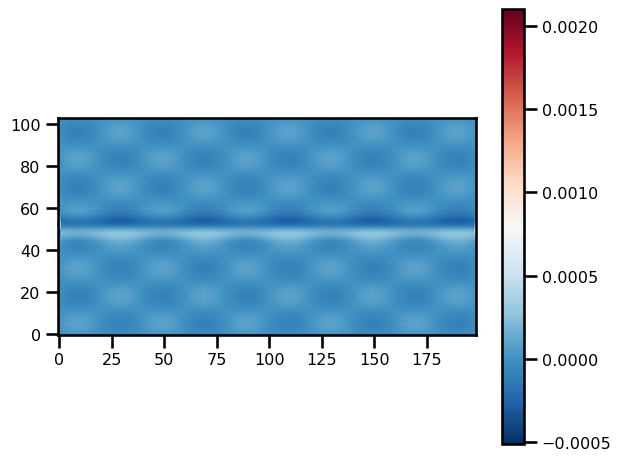

In [27]:
fig, ax = plt.subplots()

pts = ax.imshow(state_update.h[1:-1, 1:-1].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()

pts = ax.imshow(state_update.u[1:-1, 1:-1].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()

pts = ax.imshow(state_update.v[1:-1, 1:-1].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

## Time Stepping

In [38]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain

dt = 0.125 * min(h_domain.dx[0], h_domain.dx[1]) / np.asarray(params.phase_speed)
print(f"Step Size (dt): {pd.to_timedelta(dt, unit='second')}")

tmin = 0.0
tmax = pd.to_timedelta(.5, unit="days").total_seconds()
num_save = 60

Step Size (dt): 0 days 00:00:19.954714275


In [39]:
pd.to_timedelta(dt, unit="seconds")

Timedelta('0 days 00:00:19.954714275')

In [40]:
import pandas as pd

In [41]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = ShallowWater2D(t_domain=t_domain, saveat=saveat)

### Integration

In [ ]:
# Euler, Constant StepSize
solver = dfx.Dopri5()

# Tolerances
# stepsize_controller = dfx.ConstantStepSize()
rtol = 1e-3
atol = 1e-4
stepsize_controller = dfx.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=dt
)

# SPATIAL DISCRETIZATION
params_init = Params(
    gravity=9.81, depth=100.0, coriolis_f0=2e-4, coriolis_beta=2e-11, 
)
state_init = State.init_state(params)


# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params_init,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

In [ ]:
for ivar in sol.ys:
    fig, ax = plt.subplots(figsize=(12, 8))
    pts = ax.imshow(ivar[-1][2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
    plt.colorbar(pts)
    plt.tight_layout()

## Analysis

In [34]:
ds_results = xr.Dataset(
    data_vars={
        "u": (("time", "x", "y"), sol.ys.u),
        "v": (("time", "x", "y"), sol.ys.v),
        "h": (("time", "x", "y"), sol.ys.h),
    },
    coords={
        "time": (("time"), sol.ts),
        "x": (("x"), domain.coords[0]),
        "y": (("y"), domain.coords[1]),
    },
)
ds_results

<xarray.Dataset>
Dimensions:  (time: 60, x: 201, y: 105)
Coordinates:
  * time     (time) float64 0.0 1.464e+03 2.929e+03 ... 8.494e+04 8.64e+04
  * x        (x) float64 0.0 5e+03 1e+04 1.5e+04 ... 9.9e+05 9.95e+05 1e+06
  * y        (y) float64 0.0 5e+03 1e+04 1.5e+04 ... 5.1e+05 5.15e+05 5.2e+05
Data variables:
    u        (time, x, y) float64 4.02e-73 2.512e-70 ... 2.512e-70 4.02e-73
    v        (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    h        (time, x, y) float64 103.7 103.7 103.7 103.7 ... 96.33 96.33 96.33

In [35]:
from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_p_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)
    time = sub.v.time.values / 86400

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax = kwargs.pop("vmax", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(15, 4.5)

    ax = fig.subplots(
        ncols=3,
    )

    # HEIGHT
    cbar_kwargs = {"label": "Height [m]"}
    pts = sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[0],
        cmap="viridis",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs,
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.contour(
        ax=ax[0],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[0].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # U-VELOCITY
    cbar_kwargs = {"label": "U-Velocity [ms$^{-1}$]"}
    vmin = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).min()
    vmax = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).max()
    pts = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[1],
        cmap="coolwarm",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.u.isel(x=slice(1, -2), y=slice(1, -1)).plot.contour(
        ax=ax[1],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[1].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # V-VELOCITY
    cbar_kwargs = {"label": "V-Velocity [ms$^{-1}$]"}
    vmin = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).min()
    vmax = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).max()
    pts = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).plot.pcolormesh(
        ax=ax[2],
        cmap="coolwarm",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.v.isel(x=slice(1, -1), y=slice(1, -2)).plot.contour(
        ax=ax[2],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')

    pts = ax[2].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    plt.tight_layout()
    return None, None


from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_h_ke_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)
    time = sub.v.time.values / 86400

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax = kwargs.pop("vmax", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(10, 4.5)

    ax = fig.subplots(
        ncols=2,
    )

    # HEIGHT
    cbar_kwargs = {"label": "Height [m]"}
    pts = sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[0],
        cmap="viridis",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs,
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.contour(
        ax=ax[0],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[0].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # U-VELOCITY
    sub["ke"] = np.sqrt(0.5 * (sub.u**2 + sub.v**2))
    cbar_kwargs = {"label": "√ Kinetic Energy [ms$^{-1}$]"}
    vmin = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).min()
    vmax = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).max()
    pts = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.pcolormesh(
        ax=ax[1],
        cmap="YlGnBu_r",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.contour(
        ax=ax[1],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[1].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    plt.tight_layout()
    return None, None


from pathlib import Path


def create_movie(
    var,
    name,
    plotfunc=custom_plot_p_layers,
    framedim: str = "steps",
    file_path=None,
    **kwargs,
):
    if file_path is not None:
        file_name = Path(file_path).joinpath(f"movie_{name}.gif")
    else:
        file_name = Path(f"./movie_{name}.gif")

    mov = Movie(
        var, plotfunc=plotfunc, framedim=framedim, **kwargs, dpi=200, input_check=False
    )
    mov.save(
        file_name,
        remove_movie=False,
        progress=True,
        framerate=3,
        gif_framerate=3,
        overwrite_existing=True,
        gif_resolution_factor=0.5,
        parallel=False,
    )

    return None

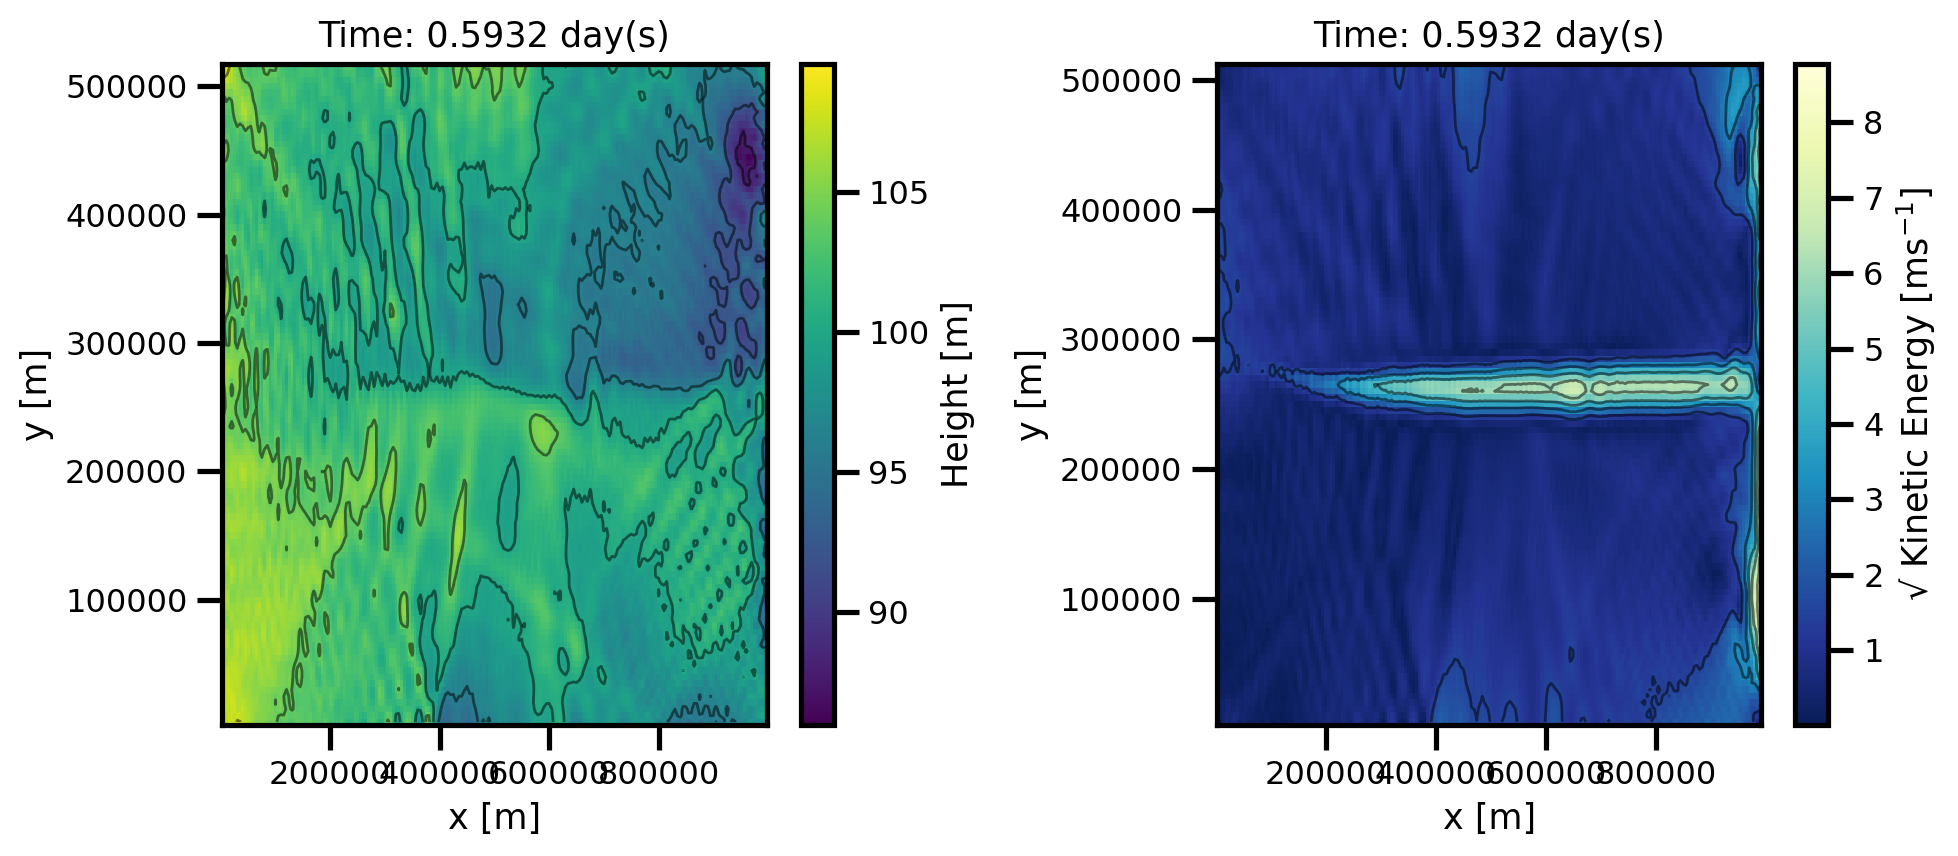

In [36]:
%matplotlib inline
mov = Movie(
    ds_results.transpose("time", "y", "x"),
    plotfunc=custom_plot_h_ke_layers,
    framedim="time",
    input_check=False,
)
mov.preview(35)

In [88]:
create_movie(
    ds_results.transpose(
        "time", "y", "x"
    ),  # .sel(time=slice("2017-02-01", "2017-03-01")),
    name="swe_nonlinear",
    plotfunc=custom_plot_h_ke_layers,
    file_path="./",
    framedim="time",
    cmap="viridis",
    robust=True,
)

  0%|          | 0/60 [00:00<?, ?it/s]

Movie created at movie_swe_nonlinear.mp4
GIF created at movie_swe_nonlinear.gif
